In [1156]:
import matplotlib.pyplot as plt 
import pandas as pd
import math
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU 
from keras.layers import Merge
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Conv2D, GlobalMaxPooling2D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MaxAbsScaler

import psycopg2
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt 
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

import keras_functions
from keras_functions import *

In [3]:
binvars = get_categorical_variables([
    'all_participanttypes',
    'all_tags',
    'all_language'
])

# Initial pipeline

In [501]:
with open('set_train.txt') as f:
    train_handles = [h.strip() for h in f.readlines()]
with open('set_test.txt') as f:
    test_handles = [h.strip() for h in f.readlines()]
with open('set_val.txt') as f:
    val_handles = [h.strip() for h in f.readlines()]

In [910]:
# user columns can be out of order, use tourist's as correct order
with open('rnn_train/tourist.csv') as f:
    correct_cols = [t.strip() for t in f.readline().split(',')]

In [409]:
user_batch = 5#len(test_handles)

In [1110]:
from os.path import exists
reload(keras_functions)
maxtimepts = 500

th = [ "abyssmall", "razia_sultana", "ufo", "williamhu08", "rdfz_yjy", "k21", "rudradevbasak", "ch_egor", "FreeMoneyCity", "Gomhog", "Life_is_like_a_boat", "MikhailRubinchik", "Oleg_Smirnov", "jiangshibiao", "Dembel", "Logic_zys", "Shayan_Jahan", "dc.", "wakaka", "chnluyi", "Koreyoshi_", "vlecomte", "AleksanderBalobanov", "Gerald", "hex539", "lovro", "MKLOL", "RNS", "gskhirtladze", "jzzhu", "Ai_AA", "JeBeK", "MHR", "alex256", "darknstd", "dragoon", "feyat" ]
X, Y, lens_tr, maxt = keras_functions.get_train_data(th, binvars, correct_cols, maxtimepts)

Xval, Yval, lens_val, maxt = keras_functions.get_train_data(val_handles[0:10], binvars, correct_cols, maxtimepts)

rnn_train/abyssmall.csv
rnn_train/razia_sultana.csv
rnn_train/ufo.csv
rnn_train/williamhu08.csv
rnn_train/rdfz_yjy.csv
rnn_train/k21.csv
rnn_train/rudradevbasak.csv
rnn_train/ch_egor.csv
rnn_train/FreeMoneyCity.csv
rnn_train/Gomhog.csv
rnn_train/Life_is_like_a_boat.csv
rnn_train/MikhailRubinchik.csv
rnn_train/Oleg_Smirnov.csv
rnn_train/jiangshibiao.csv
rnn_train/Dembel.csv
rnn_train/Logic_zys.csv
rnn_train/Shayan_Jahan.csv
rnn_train/dc..csv
rnn_train/wakaka.csv
rnn_train/chnluyi.csv
rnn_train/Koreyoshi_.csv
rnn_train/vlecomte.csv
rnn_train/AleksanderBalobanov.csv
rnn_train/Gerald.csv
rnn_train/hex539.csv
rnn_train/lovro.csv
rnn_train/MKLOL.csv
rnn_train/RNS.csv
rnn_train/gskhirtladze.csv
rnn_train/jzzhu.csv
rnn_train/Ai_AA.csv
rnn_train/JeBeK.csv
rnn_train/MHR.csv
rnn_train/alex256.csv
rnn_train/darknstd.csv
rnn_train/dragoon.csv
rnn_train/feyat.csv


ValueError: too many values to unpack

In [1111]:
reload(keras_functions)
X, Y, lens_tr, maxt, colnames = keras_functions.get_train_data(['sanket407'], binvars, correct_cols, maxtimepts) #jiyutian

rnn_train/sanket407.csv


In [1091]:
maxt

41

In [525]:
th2 = [ "123qws", "613", "Alona", "AstroConjecture", "chipchip3412", "hmich   ", "mstczuo", "pandazcy", "Fefer_Ivan", "edward_mj", "jerjeriscute", "-Wave-", "Constantius", "I_dont_have_girlfriend", "SealView", "antonkov" ]
Xval, Yval, lens_val, maxt = keras_functions.get_train_data(th2, binvars, correct_cols, maxtimepts)

rnn_train/123qws.csv
rnn_train/613.csv
rnn_train/Alona.csv
rnn_train/AstroConjecture.csv
rnn_train/chipchip3412.csv
rnn_train/hmich   .csv
rnn_train/mstczuo.csv
rnn_train/pandazcy.csv
rnn_train/Fefer_Ivan.csv
rnn_train/edward_mj.csv
rnn_train/jerjeriscute.csv
rnn_train/-Wave-.csv
rnn_train/Constantius.csv
rnn_train/I_dont_have_girlfriend.csv
rnn_train/SealView.csv
rnn_train/antonkov.csv


In [926]:
maxt

46

# Scaling
RATING MUST BE ON THE SAME SCALE


In [1100]:
Xflat = np.concatenate(X)
print Xflat.shape
Xflat = np.reshape(Xflat, [Xflat.shape[0]*Xflat.shape[1], Xflat.shape[2]])
print Xflat.shape
#scaler = MaxAbsScaler().fit(Xflat)

(6, 500, 109)
(3000, 109)


In [1101]:
xmax = np.max(Xflat, axis=0)
xmax[xmax == 0] = 1
xmax[colnames.index('smoothed_3months')]
xmax[colnames.index('problem_rating')]

5000.0

In [1217]:
month = 3
colnames_rate = ['smoothed_%dmonths'%month, 'oldrating', 'problem_rating']
maxrating = 5000.0
idx_rate = [colnames.index(c) for c in colnames_rate]
xmax[idx_rate] = maxrating

In [1197]:
np.array(colnames)[keepidx]

array(['CHALLENGED', 'COMPILATION_ERROR', 'IDLENESS_LIMIT_EXCEEDED',
       'MEMORY_LIMIT_EXCEEDED', 'OK', 'PRESENTATION_ERROR',
       'RUNTIME_ERROR', 'SKIPPED', 'TIME_LIMIT_EXCEEDED', 'WRONG_ANSWER',
       'hours_solve_to_contest', 'hours_submit_to_contest',
       'hours_submit_to_solve', 'oldrating', 'points', 'problem_rating',
       'rank', 'smoothed_3months', 'REJECTED', 'FAILED', 'CRASHED',
       'TESTING', 'PARTIAL'], 
      dtype='|S25')

In [1213]:
colnames.index('smoothed_3months')

35

In [1219]:
java = [ 'Java 6', 'Java 8', 'Java 8 ZIP', 'Java 7' ] 

python = [ 'Python 3', 'Python 2', 'PyPy 2', 'PyPy 3']

lowlevel = [
 'GNU C++14',
 'GNU C',
 'MS C++',
 'GNU C++',
 'GNU C++0x',
 'MS C#',
 'GNU C11',
 'GNU C++11 ZIP',
 'GNU C++11',
 'Mono C#',
 'Delphi',
]

unconventional = [ 'Haskell', 'Factor', 'Picat', 'Secret_171', 'PHP',
 'Tcl', 'Scala', 'Io', 'FPC', 'J', 'Rust', 'JavaScript', 'Ada', 'Go', 'Cobol', 'Befunge',
 'Roco', 'Ruby', 'Kotlin', 'F#', 'Perl', 'Pike', 'D', 'Ocaml' ]

binvars = ['implementation',
 'two pointers',
 'data structures',
 '*special',
 'probabilities',
 'divide and conquer',
 'shortest paths',
 'meet-in-the-middle',
 'trees',
 'matrices',
 'graph matchings',
 'expression parsing',
 'graphs',
 'ternary search',
 'dfs and similar',
 'combinatorics',
 'string suffix structures',
 'games',
 'binary search',
 '2-sat',
 'brute force',
 'hashing',
 'dsu',
 'chinese remainder theorem',
 'flows',
 'sortings',
 'number theory',
 'fft',
 'greedy',
 'schedules',
 'math',
 'strings',
 'bitmasks',
 'geometry',
 'dp',
 'constructive algorithms',
 'Mysterious Language',
 'FALSE',
          ]

In [1205]:
np.array(colnames)[keepidx]

array(['CHALLENGED', 'COMPILATION_ERROR', 'IDLENESS_LIMIT_EXCEEDED',
       'MEMORY_LIMIT_EXCEEDED', 'OK', 'PRESENTATION_ERROR',
       'RUNTIME_ERROR', 'SKIPPED', 'TIME_LIMIT_EXCEEDED', 'WRONG_ANSWER',
       'hours_solve_to_contest', 'hours_submit_to_contest',
       'hours_submit_to_solve', 'oldrating', 'points', 'problem_rating',
       'rank', 'smoothed_3months', 'REJECTED', 'FAILED', 'CRASHED',
       'TESTING', 'PARTIAL'], 
      dtype='|S25')

# Define model

In [915]:
reload(keras_functions)
batchsize = [1, X[0].shape[1], X[0].shape[2]]
gru1 = 10
gru2 = 1
dense = 10
model = keras_functions.create_model([gru1, gru2, dense], batchsize)

In [649]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_15 (Masking)         (1, 500, 105)             0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 10)                   4640      
_________________________________________________________________
dropout_24 (Dropout)         (1, 10)                   0         
_________________________________________________________________
dense_21 (Dense)             (1, 1)                    11        
Total params: 4,651
Trainable params: 4,651
Non-trainable params: 0
_________________________________________________________________


In [650]:
optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])

In [1220]:
#all_lang = set(all_lang)
keepidx = [i for i in range(len(colnames)) if colnames[i] not in binvars]
binidx = [i for i in range(len(colnames)) if colnames[i] in binvars]
print len(np.array(colnames)[keepidx])
print np.array(colnames)[keepidx]

28
['CHALLENGED' 'COMPILATION_ERROR' 'CONTESTANT' 'GYM'
 'IDLENESS_LIMIT_EXCEEDED' 'MEMORY_LIMIT_EXCEEDED' 'OK'
 'OUT_OF_COMPETITION' 'PRACTICE' 'PRESENTATION_ERROR' 'RUNTIME_ERROR'
 'SKIPPED' 'TIME_LIMIT_EXCEEDED' 'VIRTUAL' 'WRONG_ANSWER'
 'hours_solve_to_contest' 'hours_submit_to_contest' 'hours_submit_to_solve'
 'oldrating' 'points' 'problem_rating' 'rank' 'smoothed_3months' 'REJECTED'
 'FAILED' 'CRASHED' 'TESTING' 'PARTIAL']


In [1113]:
print np.array(colnames)[keepidx]

['CHALLENGED' 'COMPILATION_ERROR' 'IDLENESS_LIMIT_EXCEEDED'
 'MEMORY_LIMIT_EXCEEDED' 'OK' 'PRESENTATION_ERROR' 'RUNTIME_ERROR'
 'SKIPPED' 'TIME_LIMIT_EXCEEDED' 'WRONG_ANSWER' 'hours_solve_to_contest'
 'hours_submit_to_contest' 'hours_submit_to_solve' 'oldrating' 'points'
 'problem_rating' 'rank' 'smoothed_3months' 'REJECTED' 'FAILED' 'CRASHED'
 'TESTING' 'PARTIAL']


In [1117]:
maxy = 300.0
epochs = 200
history = []
s = 0
model.reset_states()

gru1 = 10
gru2 = 4
dense = 10
optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.01)

xin = X[s]/xmax
xin = xin[:, keepidx]
yin = Y[s]/maxy
batchsize = xin.shape

#model = keras_functions.create_model([gru1, gru2, dense], batchsize)
model = Sequential()
model.add(Masking(mask_value=0, batch_input_shape = batchsize))

model.add(GRU(
    gru1,
    return_sequences=True,
    stateful=False,
    batch_input_shape=batchsize,
    dropout=0.5,
    use_bias=False
))

model.add(GRU(
    gru2,
    return_sequences=False,
    stateful=True,
    batch_input_shape=batchsize,
    dropout=0.5,
    use_bias=False
))

model.add(Dense(50, activation='tanh', use_bias=False))
model.add(Dropout(0.5))

model.add(Dense(1, activation='tanh', use_bias=False))

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])

#history = model.fit(xin, yin, epochs=epochs, shuffle=False, batch_size=batchsize[0])
for i in range(epochs):
    h = model.fit(xin, yin, epochs=1, shuffle=False, batch_size=batchsize[0], verbose=0)
    model.reset_states()
    history.append(h)

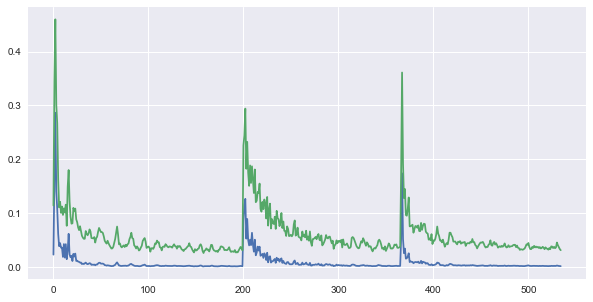

In [1223]:
plt.rcParams['figure.figsize'] = (10, 5)
loss = np.concatenate([h.history['loss'] for h in history])
mae = np.concatenate([h.history['mean_absolute_error'] for h in history])
#loss = history.history['loss']
#mae = history.history['mean_absolute_error']
plt.plot(loss)
plt.plot(mae)

0.78586715406402352

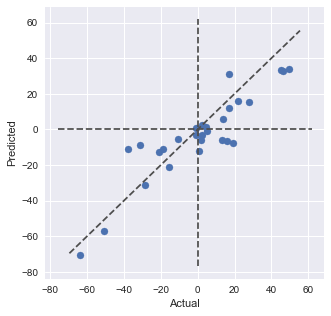

In [1224]:
model.reset_states()
y_pred = model.predict([xwide, xin], batch_size=X[0].shape[0])

y_pred = np.concatenate(y_pred)
#y_pred = y_pred.reshape(timesteps)*200.0
y_pred = y_pred*maxy

plt.rcParams['figure.figsize'] = (5,5)
plt.scatter(Y[s], y_pred)
ax = plt.gca()
diag = max(ax.get_xlim(), ax.get_ylim())
ax.plot(diag, diag, ls="--", c=".3")
ax.plot([0,0], ax.get_ylim(), ls="--", c=".3")
ax.plot(ax.get_xlim(), [0,0], ls="--", c=".3")
plt.xlabel('Actual')
plt.ylabel('Predicted')

r2_score(Y[s], y_pred)

# Tall and wide?

In [1234]:
wide = Sequential()                                                                                                                                     
wide.add(Conv1D(
    filters=1,
    kernel_size=500,
    batch_input_shape=xwide.shape,
    activation='sigmoid'
))  
print wide.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (28, 1, 1)                40501     
Total params: 40,501
Trainable params: 40,501
Non-trainable params: 0
_________________________________________________________________
None


In [1221]:
reload(keras_functions)

keepidx = [i for i in range(len(colnames)) if colnames[i] not in binvars]
binidx = [i for i in range(len(colnames)) if colnames[i] in binvars]
print len(np.array(colnames)[keepidx])
print np.array(colnames)[keepidx]

optimizer = keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.01)
xin = X[s]/xmax
xwide = xin[:, :, binidx]
xin = xin[:, :, keepidx]

print xwide.shape
print xin.shape

yin = Y[s]/maxy
batchsize = xin.shape

model = keras_functions.wide_and_deep([10, 4, 10], xwide.shape, xin.shape, verbose=1)

# ---------------------------------
# Compile model
# ---------------------------------
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])

28
['CHALLENGED' 'COMPILATION_ERROR' 'CONTESTANT' 'GYM'
 'IDLENESS_LIMIT_EXCEEDED' 'MEMORY_LIMIT_EXCEEDED' 'OK'
 'OUT_OF_COMPETITION' 'PRACTICE' 'PRESENTATION_ERROR' 'RUNTIME_ERROR'
 'SKIPPED' 'TIME_LIMIT_EXCEEDED' 'VIRTUAL' 'WRONG_ANSWER'
 'hours_solve_to_contest' 'hours_submit_to_contest' 'hours_submit_to_solve'
 'oldrating' 'points' 'problem_rating' 'rank' 'smoothed_3months' 'REJECTED'
 'FAILED' 'CRASHED' 'TESTING' 'PARTIAL']
(28, 500, 81)
(28, 500, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (28, 1, 10)               405010    
_________________________________________________________________
global_average_pooling1d_9 ( (28, 10)                  0         
Total params: 405,010
Trainable params: 405,010
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________


In [1222]:
for i in range(epochs):
    h = model.fit([xwide, xin], yin, epochs=1, shuffle=False, batch_size=batchsize[0], verbose=2)
    #h = model.fit([xwide, xin], yin, epochs=1, shuffle=False, batch_size=batchsize[0], verbose=2)
    model.reset_states()
    history.append(h)

Epoch 1/1
12s - loss: 0.0532 - mean_absolute_error: 0.1763
Epoch 1/1
3s - loss: 0.1740 - mean_absolute_error: 0.3610
Epoch 1/1
2s - loss: 0.0519 - mean_absolute_error: 0.1915
Epoch 1/1
2s - loss: 0.0257 - mean_absolute_error: 0.1279
Epoch 1/1
2s - loss: 0.0343 - mean_absolute_error: 0.1449
Epoch 1/1
2s - loss: 0.0155 - mean_absolute_error: 0.0965
Epoch 1/1
2s - loss: 0.0165 - mean_absolute_error: 0.0953
Epoch 1/1
2s - loss: 0.0196 - mean_absolute_error: 0.1084
Epoch 1/1
2s - loss: 0.0256 - mean_absolute_error: 0.1292
Epoch 1/1
2s - loss: 0.0092 - mean_absolute_error: 0.0756
Epoch 1/1
2s - loss: 0.0106 - mean_absolute_error: 0.0756
Epoch 1/1
2s - loss: 0.0097 - mean_absolute_error: 0.0770
Epoch 1/1
2s - loss: 0.0096 - mean_absolute_error: 0.0786
Epoch 1/1
2s - loss: 0.0070 - mean_absolute_error: 0.0637
Epoch 1/1
3s - loss: 0.0088 - mean_absolute_error: 0.0704
Epoch 1/1
3s - loss: 0.0094 - mean_absolute_error: 0.0761
Epoch 1/1
2s - loss: 0.0093 - mean_absolute_error: 0.0757
Epoch 1/1
3s 

2s - loss: 0.0022 - mean_absolute_error: 0.0380
Epoch 1/1
2s - loss: 0.0021 - mean_absolute_error: 0.0364
Epoch 1/1
2s - loss: 0.0021 - mean_absolute_error: 0.0375
Epoch 1/1
3s - loss: 0.0019 - mean_absolute_error: 0.0354
Epoch 1/1
3s - loss: 0.0022 - mean_absolute_error: 0.0371
Epoch 1/1
3s - loss: 0.0019 - mean_absolute_error: 0.0346
Epoch 1/1
2s - loss: 0.0020 - mean_absolute_error: 0.0353
Epoch 1/1
3s - loss: 0.0022 - mean_absolute_error: 0.0376
Epoch 1/1
3s - loss: 0.0021 - mean_absolute_error: 0.0360
Epoch 1/1
2s - loss: 0.0019 - mean_absolute_error: 0.0332
Epoch 1/1
3s - loss: 0.0020 - mean_absolute_error: 0.0366
Epoch 1/1
3s - loss: 0.0019 - mean_absolute_error: 0.0345
Epoch 1/1
3s - loss: 0.0018 - mean_absolute_error: 0.0339
Epoch 1/1
3s - loss: 0.0017 - mean_absolute_error: 0.0323
Epoch 1/1
3s - loss: 0.0019 - mean_absolute_error: 0.0353
Epoch 1/1
3s - loss: 0.0018 - mean_absolute_error: 0.0332
Epoch 1/1
3s - loss: 0.0022 - mean_absolute_error: 0.0383
Epoch 1/1
4s - loss: 0.0

KeyboardInterrupt: 